Import Libraries

In [1]:
import csv
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, classification_report
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour

import nltk

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

import re

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
%pip install gdown
import gdown

In [3]:
#Shill
download_link = 'https://drive.google.com/u/0/uc?id=1voHIcsfEhC21yr3NA_xe7xKl6tpInJbO&export=download'

gdown.download(download_link, quiet=False)

#Conversation
download_link = 'https://drive.google.com/u/0/uc?id=1IZsujps4GcQtvV3gZGnhN67kIVIt4-Qv&export=download'

gdown.download(download_link, quiet=False)

#Special Words
download_link = 'https://drive.google.com/u/0/uc?id=1lVsDkysOK7qXeogbjbvdT8z7aziQ5oeN&export=download'

gdown.download(download_link, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1voHIcsfEhC21yr3NA_xe7xKl6tpInJbO&export=download
To: /content/shill.csv
100%|██████████| 1.40M/1.40M [00:00<00:00, 10.7MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1IZsujps4GcQtvV3gZGnhN67kIVIt4-Qv&export=download
To: /content/conversation.csv
100%|██████████| 1.40M/1.40M [00:00<00:00, 10.6MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1lVsDkysOK7qXeogbjbvdT8z7aziQ5oeN&export=download
To: /content/specialWords.txt
100%|██████████| 33.3k/33.3k [00:00<00:00, 59.5MB/s]


'specialWords.txt'

## Load the dataset and remove invalid data

In [4]:
raw_data = pd.read_csv('shill.csv', sep = ';', header = None)
raw_data.columns = ["Text", "Class"]
raw_data.head(10)

,Text,Class
0,i feel lots of crypto has exhausted itself,1.0
1,How are you guys feeling today ??? :Bear: or ...,1.0
2,Did not take a trade today,1.0
3,Just entered eos long trade 👌,1.0
4,Anything good to buy now? Or did I miss it 😭,1.0
5,GL trading tonight guys. I'm off to eat dinne...,1.0
6,Okay my long position is still open on eth,1.0
7,morning guys any trades avaiable?,1.0
8,What’s everybodies thoughts today?,1.0
9,Are you guys more bullish or bearish for this ...,1.0


<Axes: >

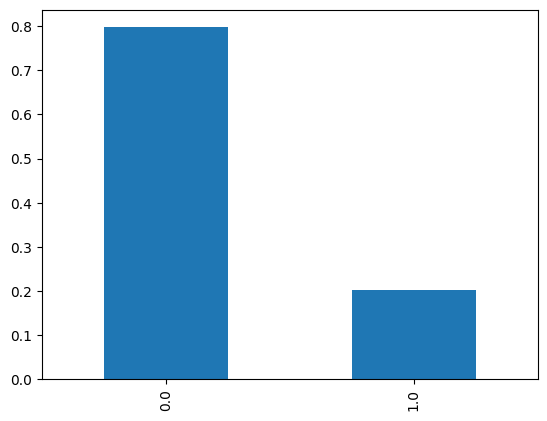

In [5]:
raw_data['Class'].value_counts(normalize = True).plot.bar()

## Data Preprocessing

In [6]:
lemmatizer = WordNetLemmatizer()
with open('specialWords.txt') as file:
    special_words = [line.strip().lower() for line in file] # lower the special words

In [7]:
## cleaning text data, remove special charactors, numbers, puncatations, stopwords removing, lower casing, skip special words
cleaned_text = []
existing_special_words = []
for idx in range(len(raw_data)):
    sentence = raw_data['Text'][idx]
    # ignore slash "/" in punctuation removing, but if slash is not there in special words, remove it
    removeSpecialChars = str(sentence).translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,.<>?\|`~-=_+"})
    pattern = r'[0-9]'
    new_string = re.sub(pattern, '', removeSpecialChars)
    new_string = re.sub(' +', ' ', new_string)
    new_string = ' '.join([word for word in new_string.split() if word not in stopwords.words("english")])
    existing_special_word = any(w in special_words for w in new_string.split())
    # keep slash for Special words, but if not special words, remove slash from the word
    new_string = ' '.join([lemmatizer.lemmatize(w).lower() if len(w)>1 and w.lower() not in special_words else w.replace("/", "").lower() for w in new_string.split() ] )
    cleaned_text.append(new_string)
    existing_special_words.append(existing_special_word)

raw_data['cleaned_text'] = cleaned_text
raw_data['existing'] = existing_special_words



In [8]:
raw_data.head(30)

,Text,Class,cleaned_text,existing
0,i feel lots of crypto has exhausted itself,1.0,feel lot crypto exhausted,True
1,How are you guys feeling today ??? :Bear: or ...,1.0,how guy feeling today bear bull,False
2,Did not take a trade today,1.0,did take trade today,False
3,Just entered eos long trade 👌,1.0,just entered eos long trade 👌,True
4,Anything good to buy now? Or did I miss it 😭,1.0,anything good buy or i miss 😭,False
5,GL trading tonight guys. I'm off to eat dinne...,1.0,gl trading tonight guy i'm eat dinner 🙂 watch ...,False
6,Okay my long position is still open on eth,1.0,okay long position still open eth,True
7,morning guys any trades avaiable?,1.0,morning guy trade avaiable,False
8,What’s everybodies thoughts today?,1.0,what’s everybodies thought today,False
9,Are you guys more bullish or bearish for this ...,1.0,are guy bullish bearish week,False


**how many entries were dropped after pre-processing**

In [9]:
## drop missing rows
dropped_dataset=raw_data.dropna()
dropped_dataset['Class'] = dropped_dataset['Class'].astype(int)
print("Droped samples : ", len(raw_data) - len(dropped_dataset))

Droped samples :  513


In [10]:
class_1_data = dropped_dataset[dropped_dataset["Class"] == 1]
class_0_data = dropped_dataset[dropped_dataset["Class"] == 0]

print("Samples of Class 0 : ", len(class_0_data.index))
print("Samples of Class 1 : ", len(class_1_data.index))

Samples of Class 0 :  23211
Samples of Class 1 :  6025


In [11]:
X_orig = dropped_dataset["Text"]
y_orig = dropped_dataset["Class"]

# **Tokenization**
- splitting sentences into words
- get Vocabulary size

In [12]:
max_len = 20
oov_token = '00_V'
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_orig)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  10145


# **Encoding the word into numeric for All Dataset**

In [13]:
X_sequences = tokenizer.texts_to_sequences(X_orig)
X_pad = pad_sequences(X_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

## Data Sampling (Undersampling)

In [14]:
# define the undersampling method
# NearMiss has 3 versions, named NearMiss-1, NearMiss-2, NearMiss-3
# By default, the technique will undersample the majority
# class to have the same number of examples as the minority class.

undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X_pad, y_orig)

In [15]:
print(len(X))

12050


# Other undersampling
**Condensed Nearest Neighbor Rule Undersampling**
```
undersample = CondensedNearestNeighbour(n_neighbors=1)
X, y = undersample.fit_resample(X_orig, y_orig)
```
**Tomek Links for Undersampling**

```
undersample = TomekLinks()
X, y = undersample.fit_resample(X_orig, y_orig)
```


**Edited Nearest Neighbors Rule for Undersampling**
```
undersample = EditedNearestNeighbours(n_neighbors=3)
X, y = undersample.fit_resample(X_orig, y_orig)
```

# **Splitting into Train and Test**

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

# **Encoding the word into numeric**

- convert list of int into numpy array

In [17]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# **Building a Transformer**

In [18]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# **Building a Model**

In [19]:
embed_dim = 40
heads = 2
neurons = 32
maxlen = 20

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

- Model Compiling

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddi  (None, 20, 40)            406600    
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_encoder (Trans  (None, 20, 40)            15872     
 formerEncoder)                                                  
                                                                 
 global_average_pooling1d (  (None, 40)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 40)                0     

# **Training a Model**

In [21]:
model_name = "checkpoint.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.0003, patience = 3, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [22]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])

Epoch 1/25
302/302 [==============================] - 20s 41ms/step - loss: 0.3817 - accuracy: 0.8338 - val_loss: 0.2001 - val_accuracy: 0.9220
Epoch 2/25
302/302 [==============================] - 3s 10ms/step - loss: 0.1925 - accuracy: 0.9257 - val_loss: 0.1711 - val_accuracy: 0.9369
Epoch 3/25
302/302 [==============================] - 3s 10ms/step - loss: 0.1668 - accuracy: 0.9385 - val_loss: 0.1813 - val_accuracy: 0.9328
Epoch 4/25
302/302 [==============================] - 4s 15ms/step - loss: 0.1529 - accuracy: 0.9444 - val_loss: 0.1528 - val_accuracy: 0.9494
Epoch 5/25
302/302 [==============================] - 3s 10ms/step - loss: 0.1404 - accuracy: 0.9492 - val_loss: 0.1559 - val_accuracy: 0.9494
Epoch 6/25
302/302 [==============================] - 3s 10ms/step - loss: 0.1393 - accuracy: 0.9501 - val_loss: 0.1709 - val_accuracy: 0.9527
Epoch 7/25
302/302 [==============================] - 4s 13ms/step - loss: 0.1321 - accuracy: 0.9536 - val_loss: 0.1734 - val_accuracy: 0.949

In [23]:
def plot_roc_curve(models, X_test):
  plt.figure(0).clf()
  for model_name in models:
    y_pred = models[model_name].predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = round(roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label="{}, AUC={}".format(model_name, round(auc, 4)))
  plt.legend()

In [24]:
def plot_precision_recall_curve(models, X_test):
  plt.figure(0).clf()

  for model_name in models:
    y_proba = models[model_name].predict(X_test)
    y_pred = models[model_name].predict(X_test)
    y_pred = [1 if pred>=0.5 else 0 for pred in y_pred]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_proba)
    lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
    plt.plot(lr_precision,lr_recall,label="{}, AUC={}".format(model_name, round(lr_auc, 4)))
  plt.legend()

In [25]:
## build a function to evaluate classification model
def model_evaluation(model, train, test, train_y, test_y):
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    pred_train = [1 if pred>=0.5 else 0 for pred in pred_train]
    pred_test = [1 if pred>=0.5 else 0 for pred in pred_test]
    print(classification_report(test_y, pred_test))
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)

    train_recall = recall_score(train_y,pred_train, average = 'weighted')
    test_recall = recall_score(test_y,pred_test, average = 'weighted')

    train_precision = precision_score(train_y,pred_train, average = 'weighted')
    test_precision = precision_score(test_y,pred_test, average = 'weighted')

    train_f1 = f1_score(train_y,pred_train, average = 'weighted')
    test_f1 = f1_score(test_y,pred_test, average = 'weighted')

    print("\n\t\t  Train score  /  Test score\n")
    print(f"Accuracy  : {train_acc} / {test_acc}")
    print(f"Recall    : {train_recall} / {test_recall}")
    print(f"Precision : {train_precision} / {test_precision}")
    print(f"F1 Score  : {train_f1} / {test_f1}")

    cm=confusion_matrix(test_y, pred_test)
    FP = cm[0][1]
    df_cm = pd.DataFrame(cm, index = [i for i in ['class:  0', 'class : 1']],
                  columns = [i for i in ['class:  0', 'class : 1']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (8,4))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.title("\nConfusion Matrix\n", color='blue', fontsize = 16)
    plt.ylabel('\nActual\n', color='blue')
    plt.xlabel('\nPredicted\n', color = 'blue')
    plt.show()
    return [test_acc, test_recall, test_precision, test_f1], FP

# **Save the model**

In [26]:
model.save_weights("transformer_model.h5")

# **Load the model**

In [27]:
model.load_weights('transformer_model.h5')

# **Save the Tokenizer**

In [28]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# **Load the Tokenizer**

In [29]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [30]:
models = {}
models["Transformer"] = model

# **Plot ROC Curve**

38/38 [==============================] - 0s 3ms/step


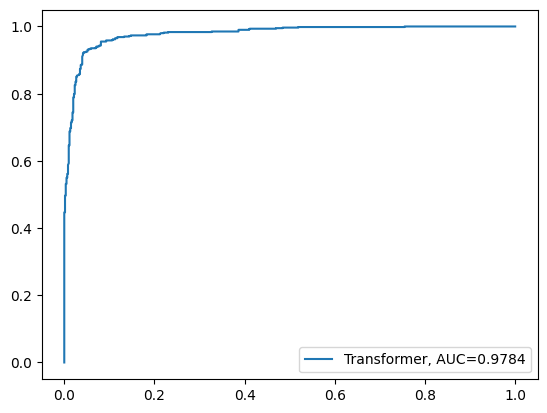

In [31]:
plot_roc_curve(models, X_test)

# **Plot PR Curve**

38/38 [==============================] - 0s 3ms/step


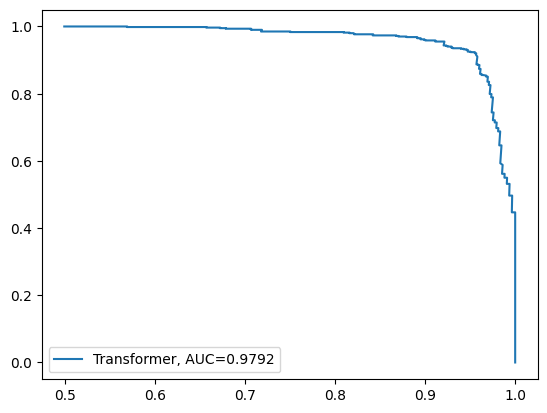

In [32]:
plot_precision_recall_curve(models, X_test)

In [33]:
y_pred = model.predict(X_test)
prediction = y_pred

38/38 [==============================] - 0s 3ms/step


In [34]:
prediction[y_pred>=0.5] = 1
prediction[y_pred<0.5] = 0

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       603
           1       0.96      0.92      0.94       602

    accuracy                           0.94      1205
   macro avg       0.94      0.94      0.94      1205
weighted avg       0.94      0.94      0.94      1205



38/38 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       603
           1       0.96      0.92      0.94       602

    accuracy                           0.94      1205
   macro avg       0.94      0.94      0.94      1205
weighted avg       0.94      0.94      0.94      1205


		  Train score  /  Test score

Accuracy  : 0.9570539419087137 / 0.9402489626556016
Recall    : 0.9570539419087137 / 0.9402489626556016
Precision : 0.9573008549234757 / 0.9407329914782501
F1 Score  : 0.9570481440996151 / 0.9402316743445671


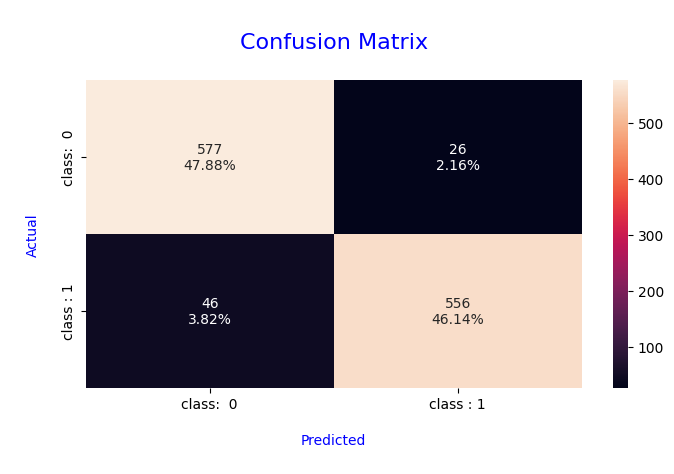

In [35]:
score, FP = model_evaluation(model, X_train, X_test, y_train, y_test)

# **Predict the new input**

In [36]:
new_input = ["i feel lots of crypto has exhausted itself", "Hello banter fam .", "Okay my long position is still open on eth	"]

In [37]:
def preprocess_input(text_list):
  cleaned_text = []
  existing = []
  for idx in range(len(text_list)):
    sentence = text_list[idx]
    removeSpecialChars = str(sentence).translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,.<>?\|`~-=_+"})
    pattern = r'[0-9]'
    new_string = re.sub(pattern, '', removeSpecialChars)
    new_string = re.sub(' +', ' ', new_string)
    new_string = ' '.join([word for word in new_string.split() if word not in stopwords.words("english")])
    existing_special_word = any(w.lower() in special_words for w in new_string.split())
    # keep slash for Special words, but if not special words, remove slash from the word
    new_string = ' '.join([lemmatizer.lemmatize(w).lower() if len(w)>1 and w.lower() not in special_words else w.replace("/", "").lower() for w in new_string.split() ] )
    cleaned_text.append(new_string)
    existing.append(existing_special_word)
  return cleaned_text, existing


- Preprocessing

In [38]:
input, existngs = preprocess_input(new_input)
input

['feel lot crypto exhausted',
 'hello banter fam',
 'okay long position still open eth']

- Word Encoding

In [39]:
input_sequences = tokenizer.texts_to_sequences(input)
input = pad_sequences(input_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [40]:
input = np.array(input)

- Predict the input

In [51]:
pred = model.predict(input)
#scoring
pred = [1 if val[0] >= 0.5 else 0 for val in pred]
replaced_pred = [1 if existngs[index] else pred[index] for index, value in enumerate(input)]


1/1 [==============================] - 0s 30ms/step


In [56]:
comp_pred = [pred, replaced_pred]
comp_df = pd.DataFrame(comp_pred).T
comp_df.columns = ["Before", "After"]
comp_df

,Before,After
0,1,1
1,0,0
2,1,1
